In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
import treeswift

In [395]:
%load_ext autoreload
%autoreload 2
    
import helpers.utils
from helpers.utils import build_summary_df
from helpers.utils import plot_genotype_confidence
from helpers.utils import clustermap_genos
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict
from helpers.utils import im_ehd, empirical_site_dists, ehd, sm_ehd, pair_metrics
from helpers.utils import plot_concordance_scatterplot, plot_concordance_distribution
from helpers.utils import plot_state_counts, report_genotype_call_stats, save_df_to_pdf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/"
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/"
lamlpro_col2_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony2.published"
lamlpro_col5_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony5.stepwise_addition_03"

In [419]:
bm_input_geno = inputs_basename + "baseMemoir_colony2_baseMemoir_genotypes.csv"
lp_map_geno = lamlpro_col2_basename + "_posterior_argmax.csv"

bm_treefile = inputs_basename + "trees/baseMemoir.colony2.published.nwk"
lp_treefile = lamlpro_col2_basename + "_tree.newick"

centroids_fname = inputs_basename + "colony2_centroids.txt"
# bm_c5_input_geno = inputs_basename + "baseMemoir_colony5_baseMemoir_genotypes.csv
# lp_c5_map_geno = lamlpro_col5_basename + "_posterior_argmax.csv"

In [420]:
bm_input_geno_df = pd.read_csv(bm_input_geno)
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)
centroids_df = pd.read_csv(centroids_fname, sep="\t", header=None, index_col=0)

In [421]:
bm_tree = treeswift.read_tree_newick(bm_treefile)
lp_tree = treeswift.read_tree_newick(lp_treefile)

#### Genotype plausibility

In [264]:
summary_df = build_summary_df(bm_input_geno_df, lp_map_geno_df)

[build_summary_df] merged rows: 8322 | LP matches: 8322 | both_present: 8322 | agree: 6773 (0.8138668589281423) | disagree_true: 1549 (0.18613314107185772)


'/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotype_probabilities.pdf'

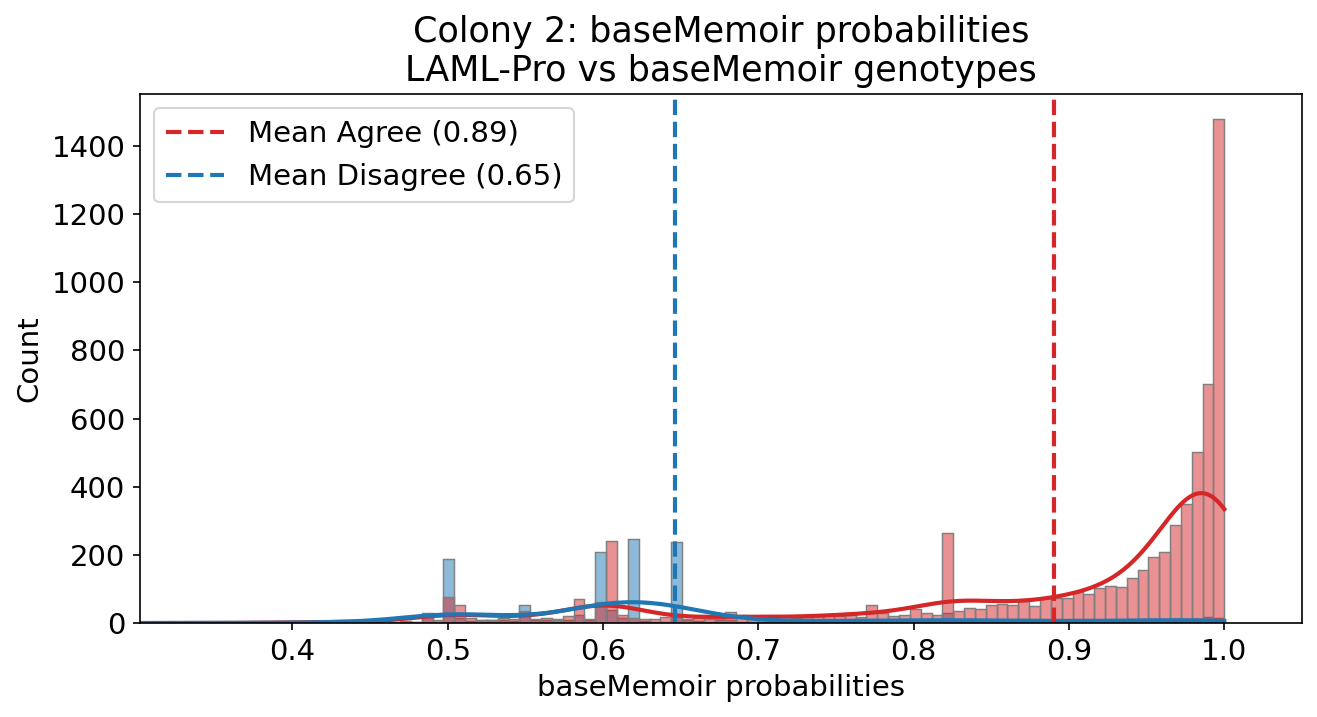

In [319]:
plot_genotype_confidence(c2_summary_df, title="Colony 2: baseMemoir probabilities\nLAML-Pro vs baseMemoir genotypes",
                         outfile=f"{plotdir}/colony2_genotype_probabilities.pdf",
                         bins=100)

In [266]:
bm_geno_df = bm_input_geno_df[['cell_name', 'target_site', 'bM_geno']]
bm_geno_df = bM_geno_df.pivot(
    index="cell_name", 
    columns="target_site", 
    values="bM_geno"
).sort_index(axis=1).fillna(-1)

In [267]:
lp_map_geno_df.columns = bm_geno_df.columns
lp_map_geno_df = lp_map_geno_df.loc[[x for x in lp_map_geno_df.index if not x.startswith('internal')], :]
lp_map_geno_df.index = [int(x) for x in lp_map_geno_df.index]
bm_geno_df.index = [int(x) for x in bm_geno_df.index]

In [269]:
(lp_map_geno_df == -1).sum().sum()

np.int64(240)

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


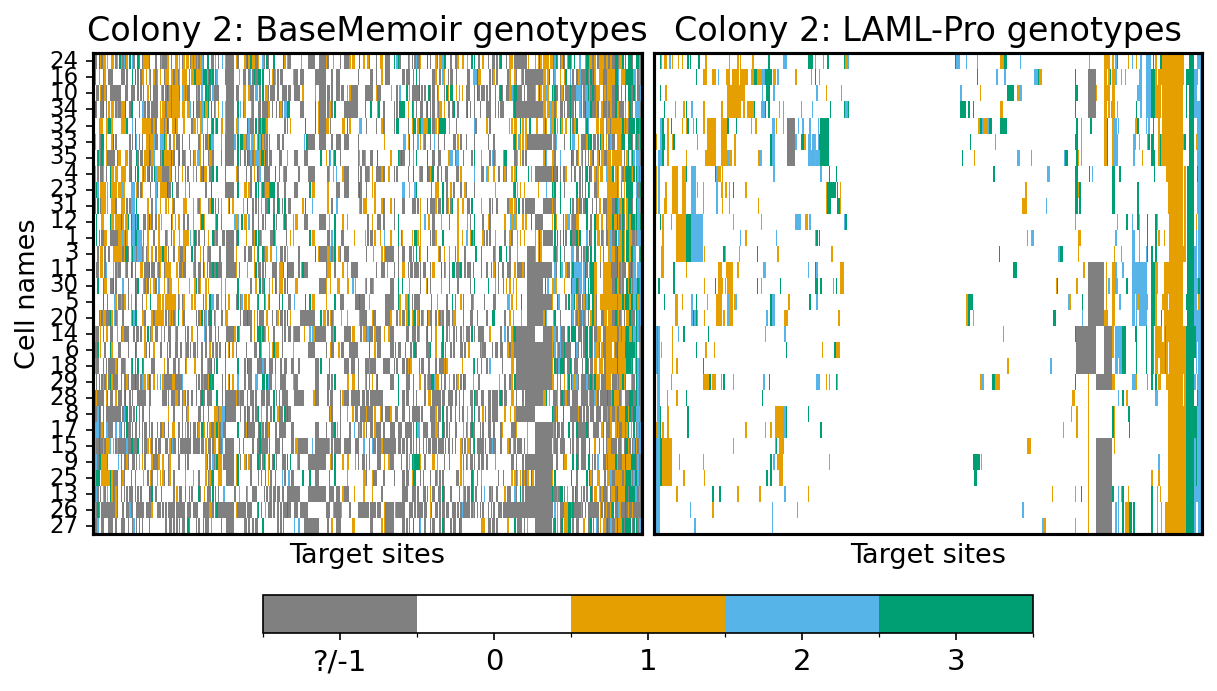

In [270]:
clustermap_genos(geno_matrix, lp_map_geno_df, metric='hamming', method='complete', title="Colony 2")

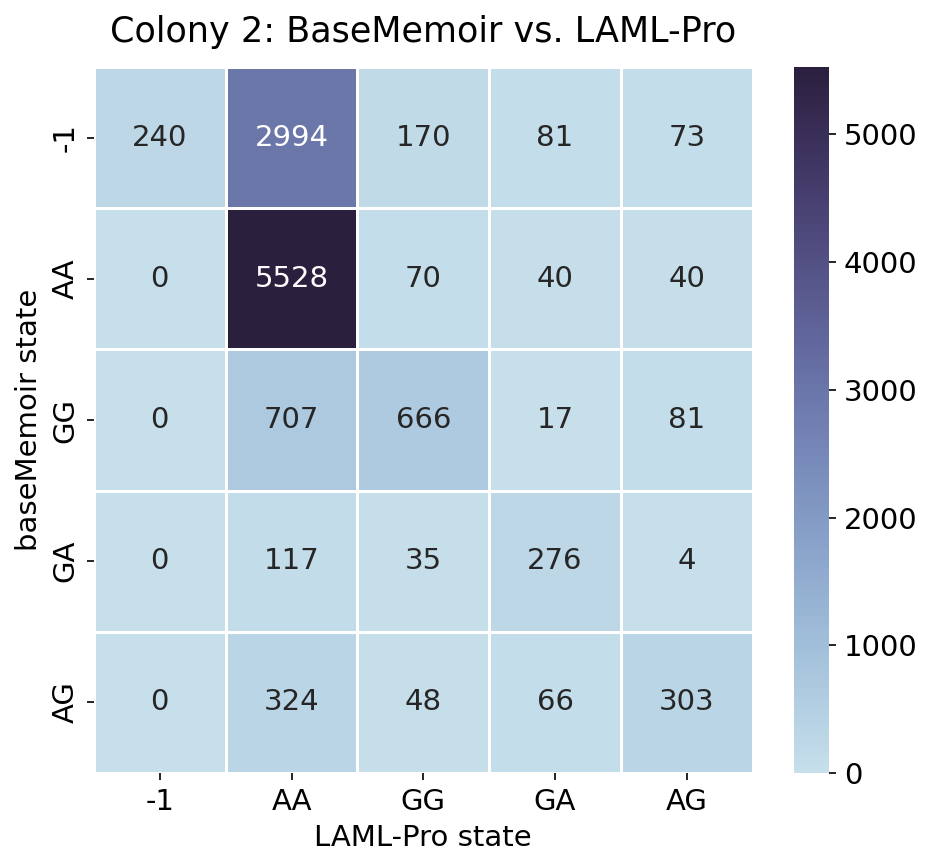

In [383]:
counts = plot_state_counts(geno_matrix, lp_map_geno_df, title="Colony 2: BaseMemoir vs. LAML-Pro",
                          outfile=f"{plotdir}/colonyf_genotype_counts.pdf")

In [397]:
stats_df = report_genotype_call_stats(counts)
save_df_to_pdf(stats_df, filename=f"{plotdir}/colony2_genotype_call_stats.pdf", title=None, floatfmt="{:.4f}", fontsize=10)

<string>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


'/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotype_call_stats.pdf'

#### Genotype concordance with tree topology

In [350]:
bm_distmat = distdict_to_df(bm_tree.distance_matrix(leaf_labels=True))
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))

In [351]:
bm_leaf_pairs = leaf_pairs(bm_distmat)
lp_leaf_pairs = leaf_pairs(lp_distmat)

In [352]:
bm_genodict = get_geno_dict(bm_input_geno_df)
hat = empirical_site_dists(bm_genodict)

In [353]:
bm_concordance = pair_metrics(bm_leaf_pairs, bm_genodict, hat)
lp_concordance = pair_metrics(lp_leaf_pairs, bm_genodict, hat)

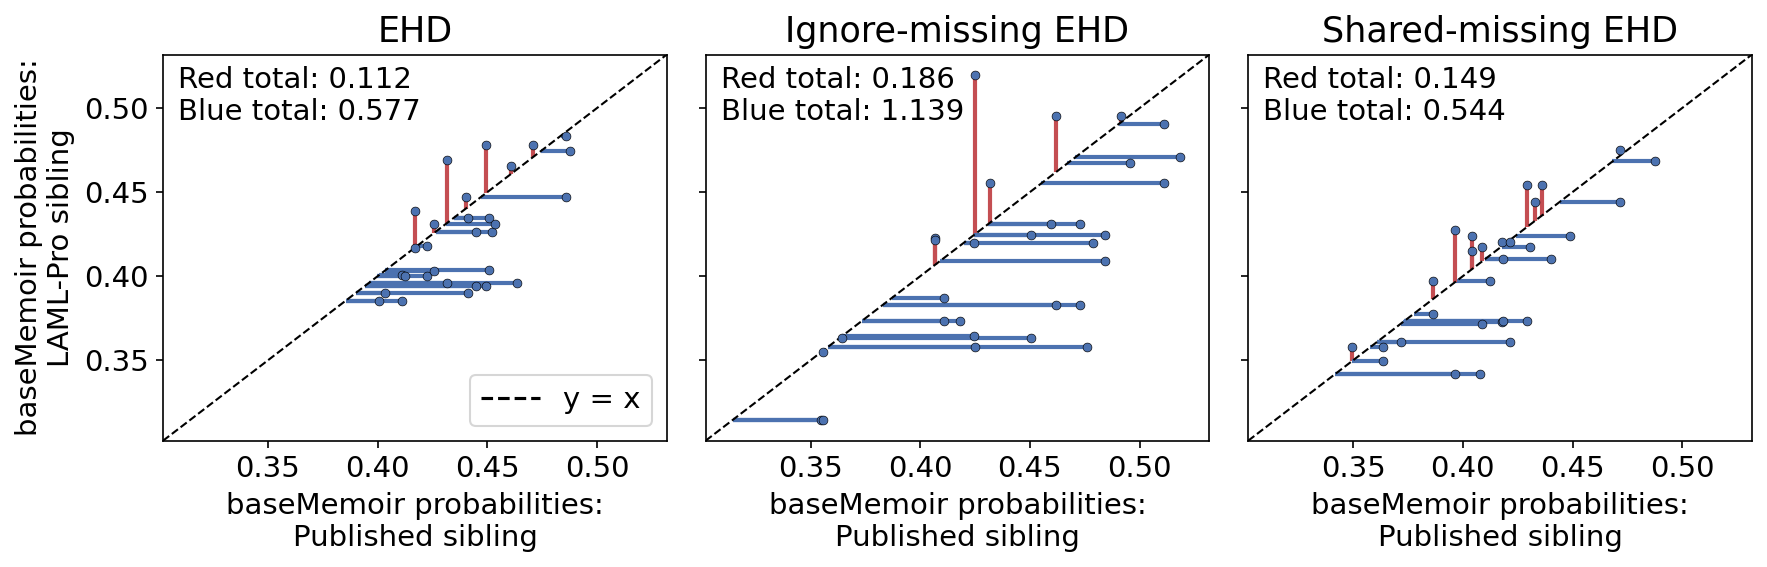

In [371]:
plot_concordance_scatterplot(bm_concordance, lp_concordance, 
                          outfile=f"{plotdir}/colony2_genotype_scatterplot.pdf")

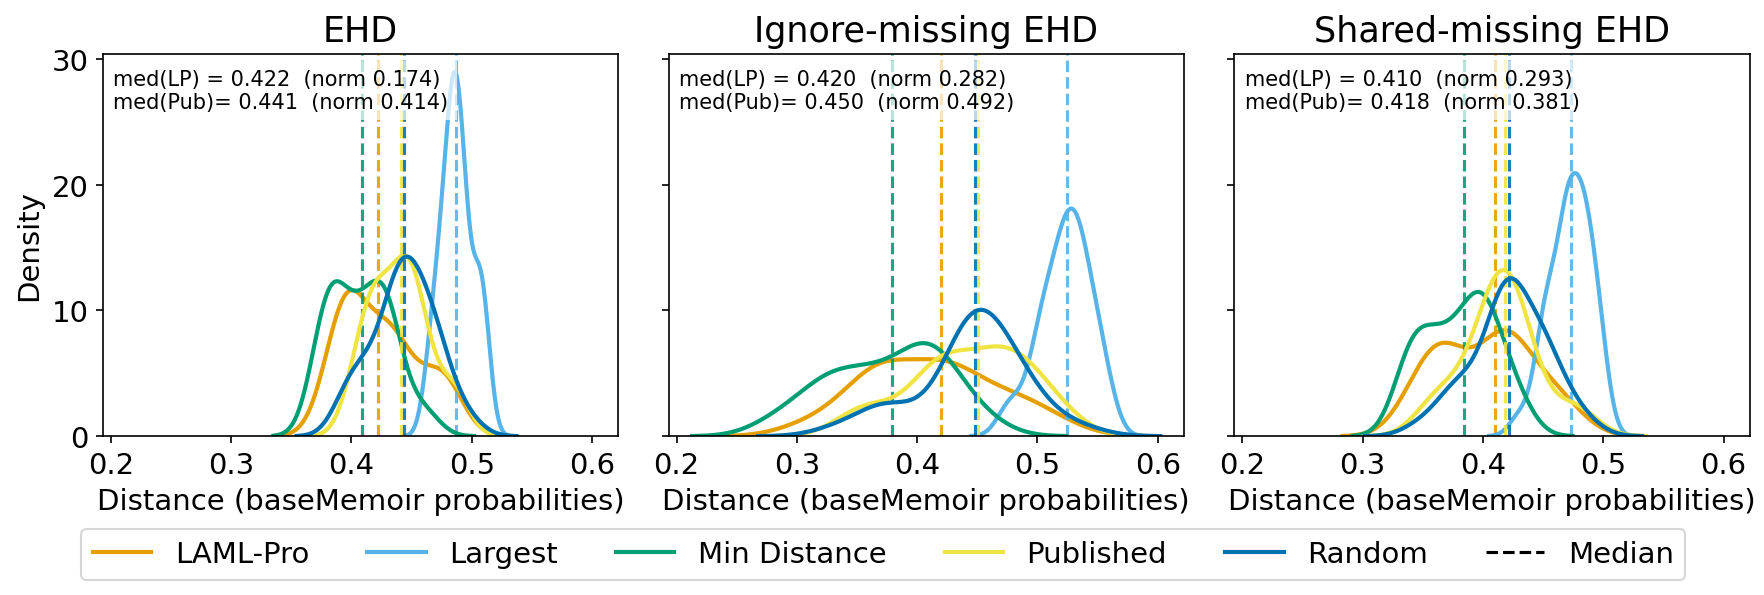

In [372]:
plot_concordance_distribution(bm_concordance, lp_concordance, bm_genodict, hat,
                          outfile=f"{plotdir}/colony2_genotype_distribution.pdf")

#### Spatial analysis

In [418]:
# scale trees

lp_tree.collapse_short_branches(0.0005)
lp_tree.root.set_edge_length(0.0)

tau = 72 # hours
bm_tree.scale_edges(tau/bm_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

var_x, var_y = centroids_df.var(axis=0)
print("Variance", var_x, var_y)
diffusion_scale = (var_x + var_y)/(2*tau)

bm_tree.scale_edges(diffusion_scale)
lp_tree.scale_edges(diffusion_scale)

print("Tree heights", bm_tree.height(), lp_tree.height())

Variance 106271.56624600854 185842.79625344044
Tree heights 146057.18124972453 146057.1812497245


In [423]:
bm_tree.write_tree_newick(bm_treefile[:-4] + ".scaled.newick")
lp_tree.write_tree_newick(lp_treefile[:-7] + ".scaled.newick")

#### Spatial visualization

In [ ]:
# plot phylogenetic distance against spatial distance and compute pearson correlation 

In [ ]:
# generate the 3D interactive plot

In [ ]:
# generate the branch length vs. z (cumulative branch length) 